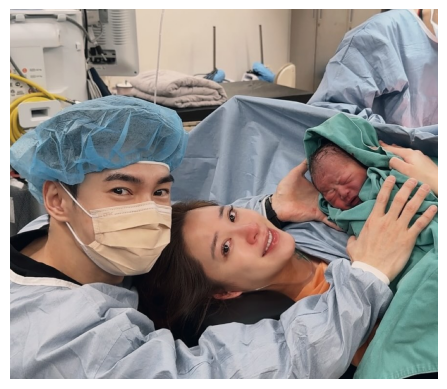

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 讀取圖片（請確保圖片路徑正確）
image_path = r"c:\Users\SHI\Desktop\KOL\ig_photos\niniouyang\niniouyang_001.jpg"
image = cv2.imread(image_path)  # 讀取圖像
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV 預設為 BGR，轉換為 RGB

# 顯示圖片
plt.imshow(image)
plt.axis("off")
plt.show()


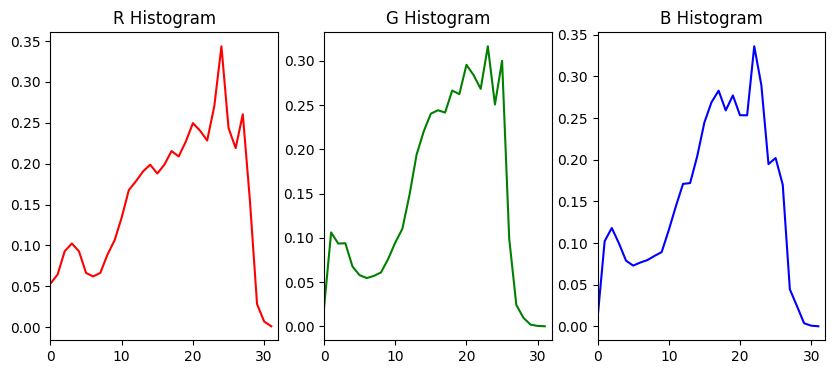

In [2]:
def compute_color_histogram(image, bins=32):
    """ 計算 RGB 顏色直方圖 """
    color_hist = []
    color_channels = ('r', 'g', 'b')  # 設定顏色通道名稱

    plt.figure(figsize=(10, 4))

    for i, color in enumerate(color_channels):
        hist = cv2.calcHist([image], [i], None, [bins], [0, 256])  # 計算每個顏色通道的直方圖
        hist = cv2.normalize(hist, hist).flatten()  # 正規化直方圖
        color_hist.append(hist)

        # 畫出直方圖
        plt.subplot(1, 3, i + 1)
        plt.plot(hist, color=color)
        plt.title(f'{color.upper()} Histogram')
        plt.xlim([0, bins])

    plt.show()
    return np.concatenate(color_hist)  # 合併 RGB 直方圖數據作為特徵

# 計算色彩直方圖
hist_features = compute_color_histogram(image)


In [3]:
def compute_color_mean_std(image):
    """ 計算影像的 RGB 平均值與標準差 """
    means, stds = cv2.meanStdDev(image)
    means = means.flatten()  # 轉成一維
    stds = stds.flatten()

    color_features = np.concatenate([means, stds])  # 合併特徵
    print(f"RGB 平均值: {means}")
    print(f"RGB 標準差: {stds}")
    return color_features

# 計算顏色平均值與標準差
color_stats = compute_color_mean_std(image)


RGB 平均值: [142.17384141 137.01791373 133.98507709]
RGB 標準差: [59.19626769 53.34969711 54.27016081]


In [ ]:
image_features = np.concatenate([hist_features, color_stats])
print(f"影像特徵向量大小: {image_features.shape}")

影像特徵向量大小: (102,)


In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm

# 路徑設定
csv_path = r"C:\Users\SHI\Desktop\KOL\analysis\kol_post&kol_feature_0425.csv"
image_root = r"C:\Users\SHI\Desktop\KOL\ig_photos"
output_dir = r"C:\Users\SHI\Desktop\KOL\feature_extraction\ComputerVision\RGB"
os.makedirs(output_dir, exist_ok=True)

# 讀取 post_id 清單
df = pd.read_csv(csv_path)
post_ids = df['post_id'].dropna().astype(str).tolist()

# 檢查哪些圖已處理過
existing_files = set(f.split('_rgb_features.npy')[0] for f in os.listdir(output_dir) if f.endswith('_rgb_features.npy'))
remaining_post_ids = [pid for pid in post_ids if pid not in existing_files]

print(f"尚未處理圖片數量：{len(remaining_post_ids)}")

# 圖像 RGB 特徵萃取
for post_id in tqdm(remaining_post_ids, desc="RGB 特徵提取"):
    folder_name = post_id.rsplit("_", 1)[0]
    image_filename = f"{post_id}.jpg"
    image_path = os.path.join(image_root, folder_name, image_filename)

    if not os.path.exists(image_path):
        print(f"找不到圖片: {image_path}")
        continue

    image = cv2.imread(image_path)
    if image is None:
        print(f"無法讀取圖片內容: {image_path}")
        continue

    # 1. 平均 RGB（3維）
    mean_rgb = image.mean(axis=(0, 1))  # [B, G, R]
    mean_rgb = mean_rgb[::-1]  # 轉為 [R, G, B]

    # 2. 色彩直方圖（每通道 8 bins × 3 通道 = 24 維）
    hist_features = []
    for ch in range(3):  # B, G, R 順序
        hist = cv2.calcHist([image], [ch], None, [8], [0, 256])
        hist = hist.flatten()
        hist = hist / hist.sum()  # normalize
        hist_features.extend(hist.tolist())
    hist_features = np.array(hist_features)

    # 3. HSV：平均亮度與飽和度（2維）
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mean_saturation = hsv[:, :, 1].mean()
    mean_brightness = hsv[:, :, 2].mean()

    # 合併所有特徵：共 3 + 24 + 2 = 29 維
    rgb_feature_vector = np.concatenate([
        mean_rgb,
        hist_features,
        [mean_brightness, mean_saturation]
    ])

    # 儲存為 .npy
    np.save(os.path.join(output_dir, f"{post_id}_rgb_features.npy"), rgb_feature_vector)

# 將npy儲存成csv檔案


In [1]:
# 將npy儲存成csv檔案
import numpy as np
import pandas as pd
import os


# 設定路徑
output_dir = r"C:\Users\SHI\Desktop\KOL\feature_extraction\ComputerVision\RGB"
output_csv_path = r"C:\Users\SHI\Desktop\KOL\feature_extraction\ComputerVision\RGB\rgb_features.csv"
# 取得所有 .npy 檔案
npy_files = [f for f in os.listdir(output_dir) if f.endswith('_rgb_features.npy')]
# 讀取每個 .npy 檔案並儲存到 DataFrame
data = []
for npy_file in npy_files:
    post_id = npy_file.split('_')[0]
    feature_vector = np.load(os.path.join(output_dir, npy_file))
    data.append([post_id] + feature_vector.tolist())
# 建立 DataFrame
df = pd.DataFrame(data, columns=['post_id'] + [f'feature_{i}' for i in range(len(feature_vector))])
# 儲存為 CSV 檔案
df.to_csv(output_csv_path, index=False)
print(f"RGB 特徵已儲存至 {output_csv_path}")

RGB 特徵已儲存至 C:\Users\SHI\Desktop\KOL\feature_extraction\ComputerVision\RGB\rgb_features.csv


In [2]:
df = pd.read_csv(r"C:\Users\SHI\Desktop\KOL\feature_extraction\ComputerVision\RGB\rgb_features.csv")
df.head

<bound method NDFrame.head of          post_id   feature_0   feature_1   feature_2  feature_3  feature_4  \
0           0119  126.067670  128.505623  120.027252   0.109275   0.144709   
1           0119  196.095773  160.736074  140.493157   0.005596   0.025512   
2     0628marika   88.745123   88.840005  124.135239   0.097111   0.171706   
3     0628marika   84.693235   84.286488   89.022565   0.398485   0.101225   
4     0628marika   80.698510   93.222083   98.109637   0.219251   0.274689   
...          ...         ...         ...         ...        ...        ...   
4265         NaN  167.343576  154.796601  145.788297   0.024696   0.086955   
4266         NaN  137.789363  132.273682  129.980069   0.003289   0.114356   
4267         NaN  152.230636  129.633321  115.922070   0.020279   0.118223   
4268         NaN  116.719377  121.041713  134.565026   0.030677   0.108605   
4269         NaN  127.938193  119.091343  113.526278   0.051252   0.211735   

      feature_5  feature_6  featu